A very quick look at the evolving coronavirus cases in LA County, starting with Jan 21st, when the first case got diagnosed in the county. Data comes from the LA County Public Health website:
http://publichealth.lacounty.gov/media/Coronavirus/
I am updating the data as it comes in. 

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('LACountyCovid.csv', header=0, index_col=0, squeeze=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'


An overview of total cases (minus recovered, but including deaths) in blue, daily new cases (in red), hospitalized at the moment (so cummulative) in green, and number of deaths registered (also cummulative) - in orange

            confirmed cases  deaths  hospitalized  daily cases month
date                                                                
2020-03-23            536.0     7.0           NaN        125.0   Mar
2020-03-24              NaN     NaN           NaN          NaN   NaN
2020-03-25              NaN     NaN           NaN          NaN   NaN
2020-03-26              NaN     NaN           NaN          NaN   NaN
2020-03-27              NaN     NaN           NaN          NaN   NaN


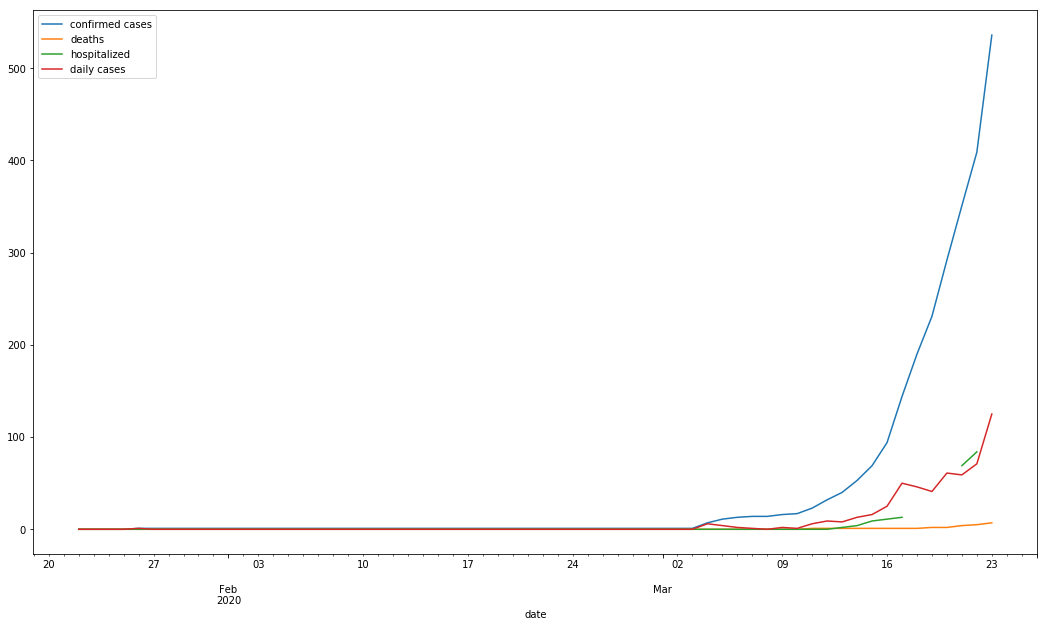

In [36]:
print(df.tail())

df.plot(figsize=(18,10))
plt.show()


A closer look at just the newly diagnosed cases every day (this is the more informative curve, which shows the number of people who have been sick and contagious for at least a week before they show up in this chart). The question is how many have these people infected before being diagnosed, and how much will this curve flatten in the next 2 weeks, when we're likely to start seeing the effects of the stay at home order.

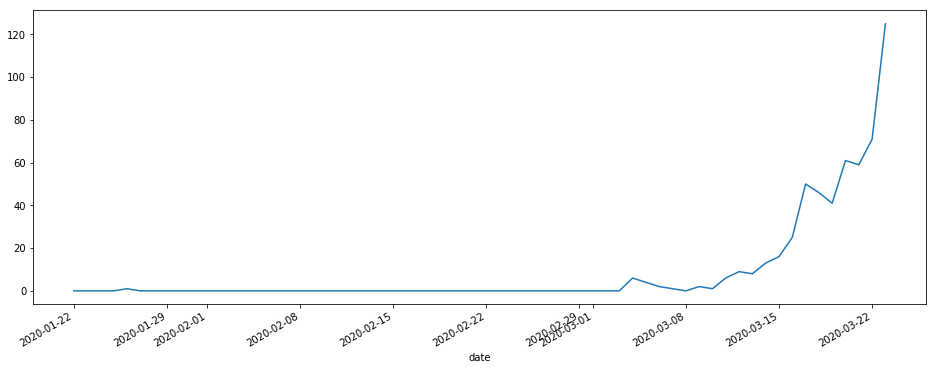

In [37]:
df['daily cases'].plot(x_compat=True, figsize=(16,6))

plt.show()

Text(0.5, 1.0, 'New confirmed cases')

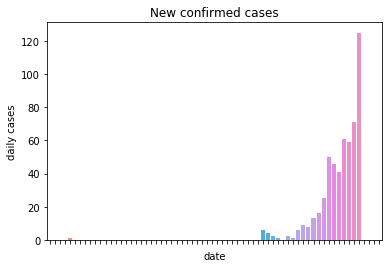

In [38]:
pl = sns.barplot(x = df.index, y = df['daily cases'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)

pl.set_title('New confirmed cases')

In [18]:
import requests 
from bs4 import BeautifulSoup 
from datetime import timedelta
  
#URL = "http://www.values.com/inspirational-quotes"
URL = "http://publichealth.lacounty.gov/media/Coronavirus/"

r = requests.get(URL) 
  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.findAll('div', attrs = {'class':'counter-block counter-text'})
dt_txt = soup.find('div', attrs = {'class': 'col-md-12 center'})
all_text = dt_txt.get_text()
new_dt = [int(s) for s in all_text.split() if s.isdigit()]
print(new_dt)
if len(table) > 2:
    print('Need to take a look, format of page has changed')
for row in table: 
    print(row.text)
    new_data.append(row.text)
     
print(new_data)


[]
409
5
['409', '5']
